## [Deprecated] Curves of fluor over space

In [ ]:
cycle = lsig.sample_cycle(cc.fire, 6)

gfpn = hv.Curve(
    data=gfp_norm,
    kdims=["Position (mm)"],
    vdims=["GFP (AU)", "Days"],
).groupby(
    "Days"
).opts(
    aspect=1.7,
    linewidth=0.4,
).overlay(
).opts(
    legend_position="right",
).options(
    {"Curve": dict(color=cycle)}
)

:NdOverlay   [Days]
   :Curve   [Position (mm)]   (GFP (AU),Days)
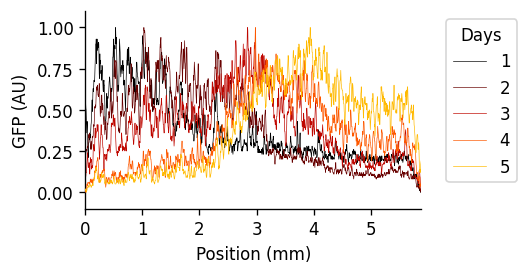

In [174]:
hv.output(gfpn, dpi=120)

<hr>

## Taking the mean of a sliding window of data

In [8]:
# Get array of distances sampled
dists = gfp_norm["GFP (AU)"]

# Define size of sliding window (odd positive integer)
windowsize = 53
shift = (windowsize - 1) // 2

In [9]:
# Number of points sampled per time-point
arrsize = data.iloc[:, 0].size

# Number of time-points
nt = 5

# Initialize column for sliding window means
## Note: Default value is `nan` to account for array shrinkage 
##   after a windowed operation
means = np.ones(arrsize * nt, dtype=np.float32) * np.nan

In [10]:
# Sort by time-points, then distance (should be sorted already, but just in case)
gfp_norm = gfp_norm.sort_values(["Days", "Position (mm)"])

# Iterate over time-points
for t in range(nt):
    
    # Get distance and fluorescence vals
    f = gfp_norm.loc[gfp_norm.Days == (t + 1), "GFP (AU)"]
    
    # Calculate windowed mean
    fmean = f.rolling(window=windowsize).mean().iloc[windowsize-1:]
    
    # Store, accounting for edge values
    means[(t * arrsize + shift):((t + 1) * arrsize - shift)] = fmean

# Add to DataFrame
gfp_norm["mean GFP (AU)"] = means

In [11]:
gfpn_points = hv.Scatter(
    gfp_norm,
    kdims=["Position (mm)"],
    vdims=["GFP (AU)", "Days"]
).groupby(
    "Days"
).opts(
    s=1,
    alpha=0.5,
).overlay(
).options(
    {
        "Scatter": dict(color=cycle, show_legend=False), 
    }
)

gfpn_means = hv.Curve(
    gfp_norm,
    kdims=["Position (mm)"],
    vdims=["mean GFP (AU)", "Days"]
).groupby(
    "Days"
).overlay(
).options(
    {
        "Curve"  : dict(color=cycle),
    }
)

:Overlay
   .NdOverlay.I :NdOverlay   [Days]
      :Curve   [Position (mm)]   (mean GFP (AU),Days)
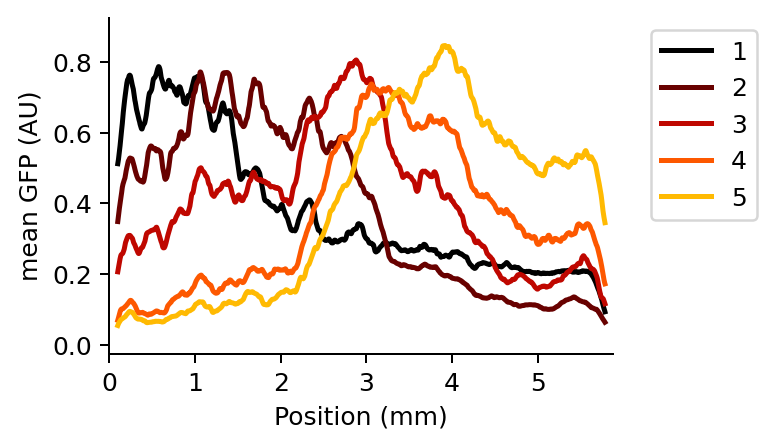

In [15]:
gfpn_smoothed = hv.Overlay(
    [gfpn_means]
).opts(  
    aspect=1.5,
    legend_position="right",
)

hv.output(gfpn_smoothed, dpi=180)

## Adding a box to show window size

In [374]:
winwidth = dists[windowsize] - dists[0]

In [375]:
# np.array([(x,y), (x+width, y), (x+width, y+height), (x, y+height)])

In [449]:
box_corners = np.array([
    (5.3,            0.75              ), 
    (5.3 + winwidth, 0.75              ),
    (5.3 + winwidth, 0.75 + winwidth/5 ),
    (5.3,            0.75 + winwidth/5 ),
])
winbox = hv.Polygons([{('x', 'y'): box_corners}]).opts(edgecolor=None, facecolor=cc.gray[0], alpha=0.25)

In [539]:
boxtext = hv.Text(5.3 + winwidth/2, 0.9, "Smoothing\nwindow", fontsize=6).opts(weight=600)

<hr>

## Final overlay

In [540]:
overlay = hv.Overlay(
    [gfpn_points, gfpn_means, winbox, boxtext]
).opts(
    aspect=1.5,
    legend_position="right",
)

:Overlay
   .NdOverlay.I  :NdOverlay   [Days]
      :Scatter   [Position (mm)]   (GFP (AU),Days)
   .NdOverlay.II :NdOverlay   [Days]
      :Curve   [Position (mm)]   (mean GFP (AU),Days)
   .Polygons.I   :Polygons   [x,y]
   .Text.I       :Text   [x,y]
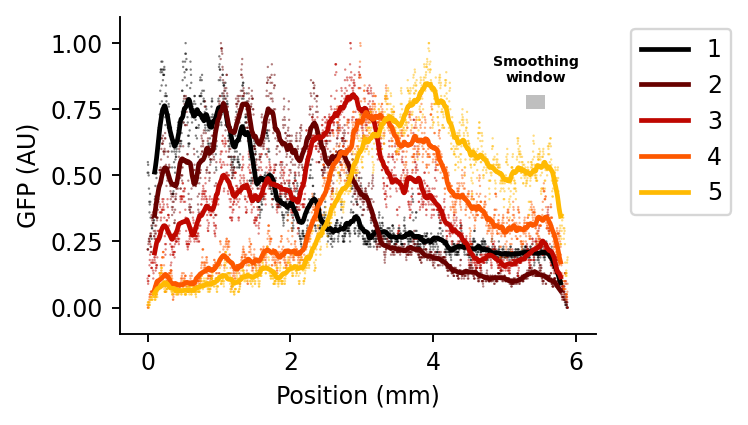

In [541]:
hv.output(overlay, dpi=170)

<hr>

## Save

In [553]:
save_figs = False

In [549]:
save_dir = abspath(join(dirname(dirname(data_fname)), "lateral_signaling", "plots"))

In [550]:
fname = "signaling_wave_experiment_fig5b"
fmt = "png"

In [551]:
fpath

'C:\\Users\\Pranav\\git\\evomorph\\lateral_signaling\\plots\\signaling_wave_experiment_fig5b.png'

In [552]:
if save_figs:
    
    fpath = join(save_dir, fname + "." + fmt)
    
    hv.save(overlay, fpath, fmt=fmt, dpi=180)